<a href="https://colab.research.google.com/github/igorlauxen/local_grape_health/blob/main/Aula_2_CNNs_fixed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aula 2 - Convolutional Neural Networks (CNNs)

Baseado em [Cat vs Dog Classification](https://colab.research.google.com/github/google/eng-edu/blob/master/ml/pc/exercises/image_classification_part2.ipynb#scrollTo=dhztKtUSFMX)

Carregando os arquivos do drive

In [12]:
# caso precise pegar os arquivo via drive, essa é opção
from google.colab import drive

# This will prompt for authorization.
# drive.mount('/content/drive')
# cd to where we have files
# mostra o que tem na pasta
#!ls /content/drive/MyDrive/unisinos/'pos graduacao'/'seminario 2 - classificação de plantas saudaveis'/dados/train/Grape_healthy/

# entra na pasta
%cd /content/drive/MyDrive/unisinos/'pos graduacao'/'seminario 2 - classificação de plantas saudaveis'/dados/train/Grape_healthy/
# mostra os primeiros conteudos da pasta
!ls -U | head -4


/content/drive/MyDrive/unisinos/pos graduacao/seminario 2 - classificação de plantas saudaveis/dados/train/Grape_healthy
698a1cd5-2ad0-4a76-bb73-65918083df56___Mt.N.V_HL 6160_180deg.JPG
508d0cc9-05ef-488a-aa84-1f28073954d4___Mt.N.V_HL 6163.JPG
9d1124c3-4be4-4998-b1f8-92b0d0f699a1___Mt.N.V_HL 8917_180deg.JPG
0f0596ab-ea6e-472b-a7d5-0a80b1d1ebb2___Mt.N.V_HL 9011_90deg.JPG


Neste notebook iremos utilizar a biblioteca [Keras](https://www.keras.io) para construir redes neurais do tipo Convolutional Neural Networks (CNNs).

Neste exemplo, iremos criar uma CNN para classificar imagens do dataset CIFAR-10. As imagens deste dataset são classificadas em 10 categorias.

Para começar, precisamos importar algumas bibliotecas.

In [9]:
import keras
#from keras.datasets import cifar10
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.callbacks import ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Para utilizar o dataset em questão, basta executar o comando abaixo.  Este comando retorna duas tuplas, as quais representam os dados de treino (entrada e saída) e de teste (entrada e saída). 
Será usado os dados importados do Google drive ao inves do cifar

In [3]:
# carregando os arquivo dos drive e colocando em uma folder tmp
# original url https://drive.google.com/file/d/1E3bGRwLfvCZpOmlvTGEvVhYucPrFZmTA/view?usp=sharing

# baseado em
# https://medium.com/@acpanjan/download-google-drive-files-using-wget-3c2c025a8b99

# caso o arquivo seja menor que 100 mega
#!wget --no-check-certificate \
#   https://docs.google.com/uc?export=download&id=1E3bGRwLfvCZpOmlvTGEvVhYucPrFZmTA -O \
#   /tmp/cats_and_dogs_filtered.zip

# como o arquivo tem mais de 100
!wget --load-cookies  \
  /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1E3bGRwLfvCZpOmlvTGEvVhYucPrFZmTA' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1E3bGRwLfvCZpOmlvTGEvVhYucPrFZmTA" -O \
   /tmp/dados.zip && rm -rf /tmp/cookies.txt

--2021-11-26 01:48:51--  https://docs.google.com/uc?export=download&confirm=RO2o&id=1E3bGRwLfvCZpOmlvTGEvVhYucPrFZmTA
Resolving docs.google.com (docs.google.com)... 108.177.15.100, 108.177.15.102, 108.177.15.138, ...
Connecting to docs.google.com (docs.google.com)|108.177.15.100|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0o-08-docs.googleusercontent.com/docs/securesc/p2b4d7i1eahg1qpqbd24qfhvhkol93q1/dtpa0ghikrhusi3ji1htnad5l77bu8mo/1637891325000/05432163893309325293/09371965146207983473Z/1E3bGRwLfvCZpOmlvTGEvVhYucPrFZmTA?e=download [following]
--2021-11-26 01:48:51--  https://doc-0o-08-docs.googleusercontent.com/docs/securesc/p2b4d7i1eahg1qpqbd24qfhvhkol93q1/dtpa0ghikrhusi3ji1htnad5l77bu8mo/1637891325000/05432163893309325293/09371965146207983473Z/1E3bGRwLfvCZpOmlvTGEvVhYucPrFZmTA?e=download
Resolving doc-0o-08-docs.googleusercontent.com (doc-0o-08-docs.googleusercontent.com)... 173.194.76.132, 2a00:1450:400c:c00::84
Connecting

In [2]:
!ls /tmp/

dap_multiplexer.fa241a2c2050.root.log.INFO.20211126-014405.62
dap_multiplexer.INFO
debugger_23pv64d9et
initgoogle_syslog_dir.0


Com o arquivo baixado, agora vamos extrair ele e criar os respectivos repositorios

In [6]:
import os
import zipfile

local_zip = '/tmp/dados.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/dados_extraidos/')
zip_ref.close()
  
base_dir = '/tmp/dados_extraidos/dados'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'test')

# Directory with our training cat pictures
train_healthy_dir = os.path.join(train_dir, 'Grape___healthy')

# Directory with our training dog pictures
train_sick_dir = os.path.join(train_dir, 'Grape___Black_rot')

# Directory with our validation cat pictures
validation_healthy_dir = os.path.join(validation_dir, 'Grape___healthy')

# Directory with our validation dog pictures
validation_sick_dir = os.path.join(validation_dir, 'Grape___Black_rot')

train_healthy_fnames = os.listdir(train_healthy_dir)
train_sick_fnames = os.listdir(train_sick_dir)

Next, let's apply the datagen transformations to a cat image from the training set to produce five random variants. Rerun the cell a few times to see fresh batches of random variants.

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


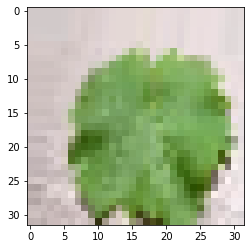

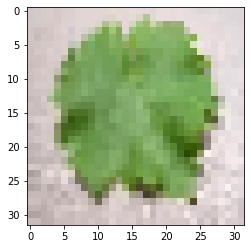

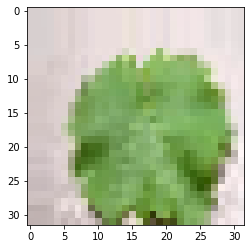

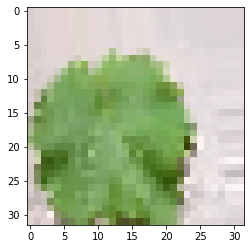

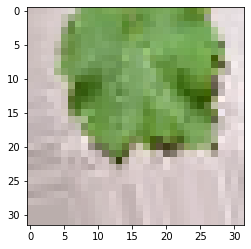

In [11]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img

img_path = os.path.join(train_healthy_dir, train_healthy_fnames[2])
img = load_img(img_path, target_size=(32, 32))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (32, 32, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 32, 32, 3)

datagen = keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    validation_split=0.2)

# The .flow() command below generates batches of randomly transformed images
# It will loop indefinitely, so we need to `break` the loop at some point!
i = 0
for batch in datagen.flow(x, batch_size=1):
  plt.figure(i)
  imgplot = plt.imshow(array_to_img(batch[0]))
  i += 1
  if i % 5 == 0:
    break

In [16]:
# carrega os conjuntos de treino e teste
# (x_train, y_train), (x_test, y_test) = cifar10.load_data()
# https://stackoverflow.com/questions/62604963/how-to-prepare-own-dataset-for-cnn

# Create the train dataset and test dataset, extract them into 2 different folders named as “train” and “test”. 
# The train folder should contain ‘n’ folders each containing images of respective classes. 
# For example, in the Dog vs Cats dataset, the train folder should have 2 folders, namely “Dogs” and “Cats” containing respective images inside them. 
# The same should be done for the test folder.
# Then, you should use tf.keras.preprocessing.image.ImageDataGenerator and its flow_from_directory function.


# pega o image generator
imageGenerator = keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=False, samplewise_center=False,
    featurewise_std_normalization=False, samplewise_std_normalization=False,
    zca_whitening=False, zca_epsilon=1e-06, rotation_range=0, width_shift_range=0.0,
    height_shift_range=0.0, brightness_range=None, shear_range=0.0, zoom_range=0.0,
    channel_shift_range=0.0, fill_mode='nearest', cval=0.0,
    horizontal_flip=False, vertical_flip=False, rescale=None,
    preprocessing_function=None, data_format=None, validation_split=0.0, dtype=None
)

# passa a folder
images, labels = next(imageGenerator.flow_from_directory(flowers))

Podemos visualizar alguns exemplos (entrada e saída) do dataset utilizando o código abaixo.

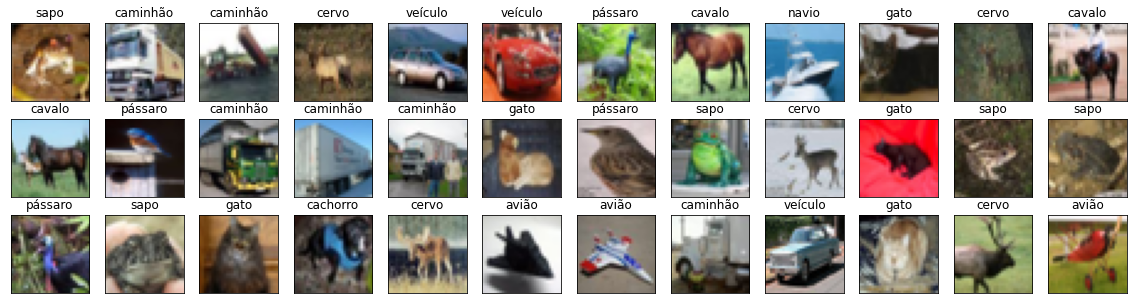

In [ ]:
cifar10_labels = ['avião', 'veículo', 'pássaro', 'gato', 'cervo', 'cachorro', 'sapo', 'cavalo', 'navio', 'caminhão']

fig = plt.figure(figsize=(20, 5))
for i in range(36):
    ax = fig.add_subplot(3, 12, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_train[i]))
    ax.set_title("{}".format(cifar10_labels[y_train[i][0]]))

Após carregar os dados, devemos tratá-los para melhorar o treinamento. No nosso caso, vamos apenas normalizar as cores (atualmente no intervalo [0,255]) para o intervalo [0,1].

In [ ]:
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

Em seguida, podemos codificar as classes utilizando o one-hot encoding. Isto vai facilitar a tarefa de aprendizado.

In [ ]:
# codificação one-hot das categorias
num_classes = len(np.unique(y_train))
print(num_classes)

10


In [ ]:
y_train = keras.utils.np_utils.to_categorical(y_train, num_classes=num_classes)
y_test = keras.utils.np_utils.to_categorical(y_test, num_classes=num_classes)

Outro passo importante é separar uma parte do conjunto de treino para validação. O objetivo é reduzir o bias do conjunto de teste.

In [ ]:
# divide os dados em treino, teste e validação
(x_train, x_valid) = x_train[5000:], x_train[:5000]
(y_train, y_valid) = y_train[5000:], y_train[:5000]

Após os tratamentos acima, podemos identificar o formato resultante dos nossos dados com os comandos abaixo.

In [ ]:
# imprime o formato dos dados de entrada
print('formato dos dados de entrada:', x_train.shape)

# imprime o tamanho dos conjuntos
print(x_train.shape[0], 'amostras de treino')
print(x_test.shape[0], 'amostras de teste')
print(x_valid.shape[0], 'amostras de validação')

formato dos dados de entrada: (45000, 32, 32, 3)
45000 amostras de treino
10000 amostras de teste
5000 amostras de validação


Processados os dados, agora devemos criar a CNN. Como de costume, trabalharemos com um modelo sequencial.

In [ ]:
model = Sequential()

Em seguida, podemos empilhar as camadas de convolução e agrupamento desejadas. Note que, ao final, incluímos uma algumas camadas densas (tal qual uma MLP). Note também que estamos utilizando Dropout para reduzir o overfitting.

In [ ]:
model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
#model.add(BatchNormalization())

#model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))

Nossa rede resultante é resumida abaixo.

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 32, 32, 16)        208       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 16)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 16, 16, 16)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 32)        2080      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 8, 8, 32)         

O próximo passo é compilar nosso modelo. Os parâmetros abaixo foram escolhidos por serem próprios para classificação.

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

Agora podemos finalmente treinar nosso modelo. **Cuidado, este processo pode demorar bastante!** 

Note que antes do treino, criamos um checkpoint. Um checkpoint permite que o modelo seja salvo em um arquivo. No nosso caso, apenas o melhor modelo será salvo. Desta forma, poderemos carregar nosso modelo posteriormente sem precisar treinar novamente a rede.

In [ ]:
# cria um checkpoint para salvar os pesos do melhor modelo encontrado no trainamento
checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1, save_best_only=True)

# treina o modelo
hist = model.fit(x_train, y_train, batch_size=32, epochs=100,
          validation_data=(x_valid, y_valid), callbacks=[checkpointer], 
          verbose=2, shuffle=True)

Epoch 1/100

Epoch 00001: val_loss improved from inf to 1.49329, saving model to model.weights.best.hdf5
1407/1407 - 12s - loss: 1.7822 - accuracy: 0.3524 - val_loss: 1.4933 - val_accuracy: 0.4550 - 12s/epoch - 9ms/step
Epoch 2/100

Epoch 00002: val_loss did not improve from 1.49329
1407/1407 - 11s - loss: 1.4420 - accuracy: 0.4804 - val_loss: 1.6110 - val_accuracy: 0.4090 - 11s/epoch - 7ms/step
Epoch 3/100

Epoch 00003: val_loss improved from 1.49329 to 1.19413, saving model to model.weights.best.hdf5
1407/1407 - 10s - loss: 1.3227 - accuracy: 0.5249 - val_loss: 1.1941 - val_accuracy: 0.5782 - 10s/epoch - 7ms/step
Epoch 4/100

Epoch 00004: val_loss did not improve from 1.19413
1407/1407 - 10s - loss: 1.2432 - accuracy: 0.5566 - val_loss: 1.4543 - val_accuracy: 0.4868 - 10s/epoch - 7ms/step
Epoch 5/100

Epoch 00005: val_loss improved from 1.19413 to 1.12156, saving model to model.weights.best.hdf5
1407/1407 - 10s - loss: 1.1993 - accuracy: 0.5714 - val_loss: 1.1216 - val_accuracy: 0.60

Treinado o modelo, podemos analisar seu desempenho através dos gráficos abaixo.

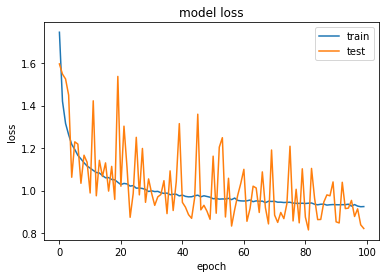

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

Exemplo 2

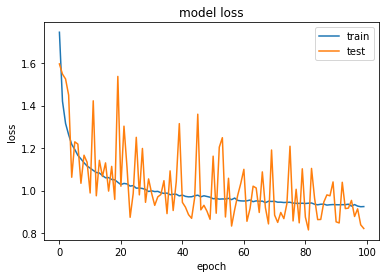

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

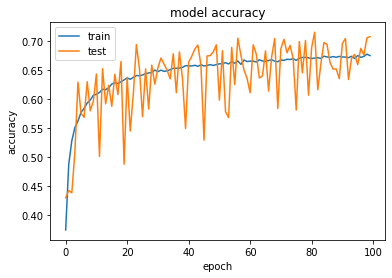

In [ ]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Após concluir o treino, podemos carregar o melhor modelo utilizando o comando abaixo.

In [ ]:
# carrega os pesos do melhor modelo encontrado no treinamento
model.load_weights('model.weights.best.hdf5')

A acurácia pode ser medida como segue.

In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)
print('\n', 'Acurácia:', score[1])


 Acurácia: 0.7017999887466431


Finalmente, podemos visualizar algumas predições do nosso modelo para entender melhor seu comportamento.

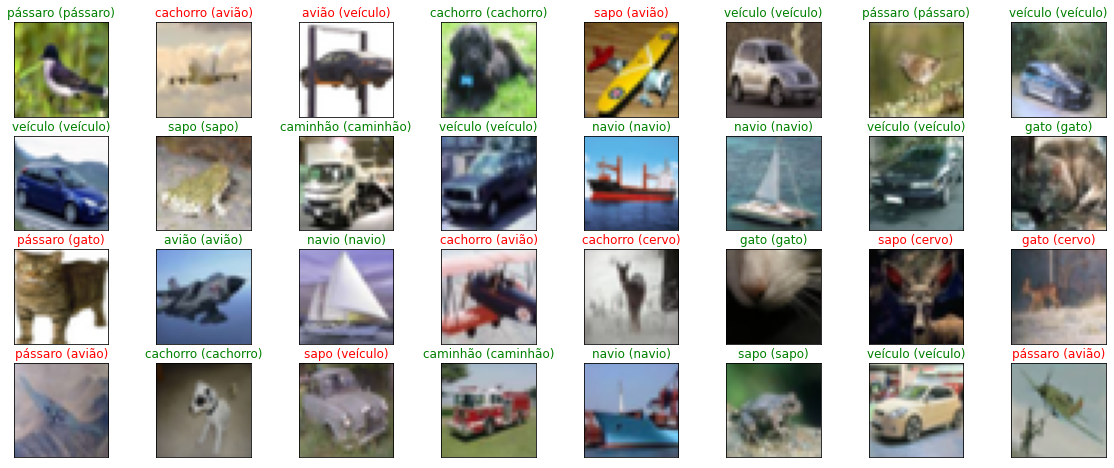

In [ ]:
# obtém as predições
y_hat = model.predict(x_test)

# define os labels (fonte: https://www.cs.toronto.edu/~kriz/cifar.html)
cifar10_labels = ['avião', 'veículo', 'pássaro', 'gato', 'cervo', 'cachorro', 'sapo', 'cavalo', 'navio', 'caminhão']

# exibe alguns exemplos aleatórios do teste, bem como sua predição e o resultado esperado
fig = plt.figure(figsize=(20, 8))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=32, replace=False)):
    ax = fig.add_subplot(4, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx = np.argmax(y_hat[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(cifar10_labels[pred_idx], cifar10_labels[true_idx]),
                 color=("green" if pred_idx == true_idx else "red"))

## Exercícios

### Exercício 1

Ajuste a rede CNN vista acima para obter uma acurácia melhor no dataset CIFAR-10. Sua tarefa consiste em modificar a arquitetura da rede (e.g., quantidade de camadas, ordem das camadas, tamanho das camadas, loss function, otimizador, número de épocas, etc.).

In [ ]:
# your answer here